# SQL 101 with duckdb and jupysql

## Jupyter + duckdb setup for sql

Before the sql even starts, I want to use jupyter notebooks + sql. I'm using duckdb inside jupyter to look at a few sql datasets. 

First up, make a new env and install the necessary libraries if necessary by:

```sh
mamba create -n sql101 python=3.11 jupyterlab duckdb duckdb-engine jupysql matplotlib openpyxl plotly
mamba active sql101
```

In [1]:
# | echo: false
import duckdb

import os
from pathlib import Path
import pandas as pd
import numpy as np
from zipfile import ZipFile
import requests

import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib import patches as mpatches
from ipywidgets import widgets

# %load_ext jupyter_ai_magics

### Setting up duckdb for jupyter

Once all the packages have been installed, setup jupyter to use duckdb. You don't need to use all the three config options below, just noting some useful ones for future reference.

the `%config SqlMagic.autopandas` in particular is useful - the sql query is returned as a pandas dataframe. This is useful as even though right now I have a small dataset, on a real project duckdb can talk to [remote databases](https://clickhouse.com/), or query [parquet files on the web](https://duckdb.org/2021/06/25/querying-parquet.html), do a query and only pull down the subset of data selected in the query.

After that, the pandas dataframe is ideal for plotting and other pythonic stuff. 

In [2]:
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

%config SqlMagic.displaycon = False  # hides con info
%config SqlMagic.autopandas = True   # output as df
#%config SqlMagic.feedback = False   # 

%sql duckdb://

## Data

I'm using the [Economist's big mac gdp source data](https://github.com/TheEconomist/big-mac-data). Pandas can directly download the csv file into a dataframe which duckdb can read, but trying to stick with most sql here, so I'm downloading the csv file to disk and reading it with duckdb directly.

Why the big mac index? To calculate the big mac index we need to use [correlated subqueries](https://duckdb.org/2023/05/26/correlated-subqueries-in-sql.html), which is a pretty advanced topic!

The final output figure @fig-big-mac-index is somewhere below, this notebook works through getting there slowly:

In [3]:
url = "https://github.com/TheEconomist/big-mac-data/raw/master/source-data/big-mac-source-data-v2.csv"

fname = "big-mac-source-data-v2.csv"

with open(fname, "wb") as file:
    file.write(requests.get(url).content)

When using `%%sql` cells in jupyter, put python variables in brackets like so: `{{var_name}}`.

The [read_csv_auto](https://duckdb.org/docs/guides/import/csv_import) should auto-magically read and convert the csv to a sql table:

In [4]:
%%sql
-- make a table bigmac from the csv file
create table if not exists bigmac as select * from read_csv_auto('{{fname}}');

select * from bigmac limit 3; -- comments can go here too!

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date
0,Argentina,ARG,ARS,2.50,1.00,8709.072,8709.072,2000-04-01
1,Australia,AUS,AUD,2.59,1.68,21746.809,33698.764,2000-04-01
2,Brazil,BRA,BRL,2.95,1.79,3501.438,6351.375,2000-04-01


So now we have a table inside a sql database.

::: {.callout-note}
sql convention is to use a lot of CAPITALS, but for fast typing and a lack of an sql formatter, I'm going lowercase. Ideally your [sql](https://dbgate.org/) writing [thingamjig](https://azure.microsoft.com/en-au/products/data-studio) should have a formatter which does that for you.
:::

## EDA and data cleanup

Data always has some issues, so taking a look:


### Metadata about the table

A sql database can have many tables, so its useful to take a look at whats there:

In [5]:
%sqlcmd tables

Name
bigmac


This should describe the table:

In [6]:
%sql describe bigmac;

,Success


The `describe bigmac` code should spit out table info, seems to be some kind of bug, but moving on, we can get the gist using the [information schema](https://duckdb.org/docs/sql/information_schema): 

In [7]:
%%sql 
SELECT COLUMN_NAME, DATA_TYPE
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'bigmac';

,column_name,data_type
0,name,VARCHAR
1,iso_a3,VARCHAR
2,currency_code,VARCHAR
3,local_price,DOUBLE
4,dollar_ex,DOUBLE
5,GDP_dollar,DOUBLE
6,GDP_local,DOUBLE
7,date,DATE


The above is not that useful, a more informative look which counts the values is:

In [8]:
%sqlcmd profile --table 'bigmac'

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date
count,1946,1946,1946,1946,1946,1943,1918,1946
unique,74,73,58,669,1497,1157,1141,37
top,Argentina,ARG,EUR,nan,nan,nan,nan,2021-07-01
freq,37,37,351,nan,nan,nan,nan,73
mean,nan,nan,nan,15816.0895,4722.5632,24790.7531,2615423.9573,nan
std,nan,nan,nan,393903.7657,100597.3791,21425.9054,9471890.5225,nan
min,nan,nan,nan,0.0,0.0,689.826,3004.341,nan
25%,nan,nan,nan,4.4500,1.0035,6577.2870,33698.7640,nan
50%,nan,nan,nan,15.0000,5.4650,17815.1920,70506.5530,nan
75%,nan,nan,nan,87.0000,32.8750,41409.6309,358689.5130,nan


### Data cleanup

So we have 3 rows without a GDP_dollar, and at least one `local_price` and `dollar_ex` of 0, so dropping those rows.
We also need `GDP_local` to be able to adjust the bigmac index, so dropping any nulls in that row too.

In [9]:
%%sql 
delete from bigmac where 
GDP_dollar is null or GDP_local is null or local_price<=0 or dollar_ex<=0;

,Success


In [10]:
rows = %sql select count(*) as N from bigmac;
f"The data set has a total of {rows.N.loc[0]} rows."

'The data set has a total of 1918 rows.'

It's a pretty clean and tidy dataset, we did loose a few rows, which in a real world case might bear more investigation, but moving on...

In [11]:
%sql select count(distinct name) as Countries, min(date), max(date) from bigmac;

,Countries,min(date),max(date)
0,73,2000-04-01,2022-07-01


We have data for 73 countries from April 2000 to July 2022.  

## Calculations in SQL

Adding some columns by calculating new ones in sql. This is where the [sql](https://duckdb.org/docs/sql/introduction) starts.

### Big mac price in USD

We want to get the US dollar price for a big mac in every country, which is easy as our data contains the local_price and dollar exchange rate. So we add a new column: `dollar_price = local_price / dollar_ex`.

In sql you can't just add a column, you first have to add it with a value type. In pandas you can do this in one step: `df["dollar_price"] = df.local_price / df.dollar_ex`. 

So here we add a new col `dollar_price` and calc its value:

In [12]:
%%sql
alter table bigmac 
    add column if not exists dollar_price DOUBLE;
update bigmac 
    set dollar_price = local_price / dollar_ex;

select * from bigmac limit 3;

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
0,Argentina,ARG,ARS,2.50,1.00,8709.072,8709.072,2000-04-01,2.500000
1,Australia,AUS,AUD,2.59,1.68,21746.809,33698.764,2000-04-01,1.541667
2,Brazil,BRA,BRL,2.95,1.79,3501.438,6351.375,2000-04-01,1.648045


The line `if not exists` is optional, but useful in this context as it prevents errors if I rerun the notebook. 

### Calculating the big mac index

Now we want to account for purchasing power parity by divinding the dollar price with the base currencies price.
The Economist uses five base currencies: `('USD', 'EUR', 'GBP', 'JPY', 'CNY')`

For simplicity's sake, I'll stick with just USD.  This is a easy calc to do in python, in SQL its a bit messy..., so I am using [Correlated Subqueries in SQL](https://duckdb.org/2023/05/26/correlated-subqueries-in-sql.html) to do this.

The dollar_price on each row is divided by the dollar_price in USD. Since we have multiple dates, the query below matches on both the date and the country code.

The inner query returns the US dollar_price for each date, so every row in the table gets divided by the right dates USD price.

::: {.callout-note}
This only works because for each unique date, there is only one row for USA.
:::

Finally, we minus the number by `-1`, as we divide the US price by its own, so its always at 1. By subtracting `-1`, we set that to zero, which makes it wasy to see how the other countries are over or under that.

In [13]:
%%sql
ALTER TABLE bigmac ADD COLUMN IF NOT EXISTS USD DOUBLE;

update bigmac as b1
    set USD = dollar_price / 
            (select b2.dollar_price from bigmac as b2
            where b2.date = b1.date
            and b2.iso_a3 = 'USA') - 1;

select * from bigmac order by date desc, name desc limit 6;

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,USD
0,Vietnam,VNM,VND,69000.00,23417.00000,3724.543,8.542019e+07,2022-07-01,2.946577,-0.427849
1,Uruguay,URY,UYU,255.00,41.91000,16756.344,7.291942e+05,2022-07-01,6.084467,0.181450
2,United States,USA,USD,5.15,1.00000,69231.400,6.923140e+04,2022-07-01,5.150000,0.000000
3,United Arab Emirates,ARE,AED,18.00,3.67305,42883.686,1.574903e+05,2022-07-01,4.900559,-0.048435
4,Turkey,TUR,TRY,47.00,17.56500,9527.683,8.448134e+04,2022-07-01,2.675776,-0.480432
5,Thailand,THA,THB,128.00,36.61250,7336.086,2.313028e+05,2022-07-01,3.496074,-0.321151


I did a few random checks and looks like the formula did use the right USD price to calculate the USD offset.

### Adjusted GDP based on big mac index

Big Mac adjusted per capita GDP is the GDP in local currency divided by the exchange rate as determined by big macs (price in local currency divivded by price in US).

The formula is: `GDP_Local / (local_price / dollar_price)`

In [14]:
%%sql
ALTER TABLE bigmac ADD COLUMN IF NOT EXISTS GDP_bigmac DOUBLE;

update bigmac as b1
    set GDP_bigmac = GDP_local / 
            (local_price / (select b2.dollar_price from bigmac as b2
            where b2.date = b1.date
            and b2.iso_a3 = 'USA'));

select * from bigmac order by date desc, name desc limit 6;

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,USD,GDP_bigmac
0,Vietnam,VNM,VND,69000.00,23417.00000,3724.543,8.542019e+07,2022-07-01,2.946577,-0.427849,6375.564885
1,Uruguay,URY,UYU,255.00,41.91000,16756.344,7.291942e+05,2022-07-01,6.084467,0.181450,14726.863618
2,United States,USA,USD,5.15,1.00000,69231.400,6.923140e+04,2022-07-01,5.150000,0.000000,69231.400000
3,United Arab Emirates,ARE,AED,18.00,3.67305,42883.686,1.574903e+05,2022-07-01,4.900559,-0.048435,45059.735594
4,Turkey,TUR,TRY,47.00,17.56500,9527.683,8.448134e+04,2022-07-01,2.675776,-0.480432,9256.997784
5,Thailand,THA,THB,128.00,36.61250,7336.086,2.313028e+05,2022-07-01,3.496074,-0.321151,9306.323554


And presto, we have a gdp per big mac, which for most countries is significantly different from each other. A couple of plots to eyeball this:

In [15]:
#| code-fold: true
country = "Pakistan"
df = %sql select * from bigmac where name in ('{{country}}')
fig = px.line(df, x="date", y=["GDP_dollar", "GDP_bigmac"], 
              title=f"{country}: GDP local vs bigmac",
              markers=True)
fig.show()

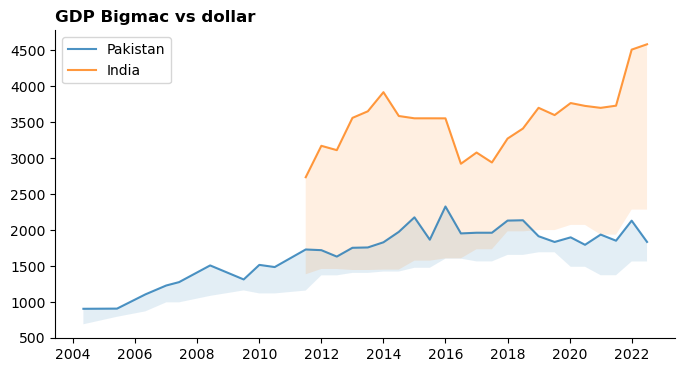

In [16]:
#| code-fold: true
df = %sql select * from bigmac;

fig, ax = plt.subplots(figsize=(8, 4))
ax.spines[["top", "right"]].set_visible(False)
ax.set_title("GDP Bigmac vs dollar", loc="left", weight="bold")

for name in ["Pakistan", "India"]:
    d = df.query("name == @name")
    ax.plot(d.date, d.GDP_bigmac, alpha=0.8, label=f"{name}")
    ax.fill_between(d.date, d.GDP_bigmac, d.GDP_dollar, alpha=0.12)
    #ax.plot(d.date, d.GDP_dollar, alpha=0.6, ls="--")

ax.legend();

This is interesting, you can see the indian dollar even though its close to the Pakistan one in GDP_dollar terms, the big mac index GDP says it buys a lot more.

### TODO: Adjusted big mac index

This uses the big mac adjusted per capita GDP price calculated above to get a adjusted dollar price for a bigmac. This looks very similar to first big mac index so left this calc for a future date.

See [Calculating the adjusted index](https://github.com/theeconomist/big-mac-data/blob/master/Big%20Mac%20data%20generator.ipynb) for details.

## Adding country data

There are a lot of countries in the index, which will make the graph a bit messy, so to add some groups to the counties (and do more sql!) I'm going to use the world banks [income dataset](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups), primary to add regions and income groups.

In [17]:
df_income = pd.read_excel(
    "https://datacatalogfiles.worldbank.org/ddh-published/0037712/DR0090755/CLASS.xlsx"
)

df_income = (
    df_income.dropna(subset=["Income group", "Economy"])
    .drop(columns="Lending category")
    .rename(columns={"Code": "iso_a3", "Income group": "income_group"})
)

# adding in the missing eurozone
euro_row = ["Eurozone", "EUZ", "Europe", "High income"]
df_income.loc[len(df_income)] = euro_row

df_income.tail(3)

,Economy,iso_a3,Region,income_group
215,South Africa,ZAF,Sub-Saharan Africa,Upper middle income
216,Zambia,ZMB,Sub-Saharan Africa,Lower middle income
217,Eurozone,EUZ,Europe,High income


No need to do this step, but for more sql goodness, lets add this as a table in our database so we can practice joining two tables:

In [18]:
%%sql
create table income as select * from df_income;
select * from income limit 3;

,Economy,iso_a3,Region,income_group
0,Aruba,ABW,Latin America & Caribbean,High income
1,Afghanistan,AFG,South Asia,Low income
2,Angola,AGO,Sub-Saharan Africa,Lower middle income


### Joining the two tables 

Here we join these two tables into a dataframe for plotting. 

I am using a left join as I want to keep all data in the bigmac table, and just add country info.

::: {.callout-warning}
Don't write sql like below, use capitals and linebreaks! 
:::

In [19]:
df_all = %sql select * from bigmac left join income on bigmac.iso_a3 = income.iso_a3 order by bigmac.date asc;
df_all.head(2)

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,USD,GDP_bigmac,Economy,iso_a3_2,Region,income_group
0,Argentina,ARG,ARS,2.50,1.00,8709.072,8709.072,2000-04-01,2.500000,0.116071,7803.328512,Argentina,ARG,Latin America & Caribbean,Upper middle income
1,Australia,AUS,AUD,2.59,1.68,21746.809,33698.764,2000-04-01,1.541667,-0.311756,29144.876973,Australia,AUS,East Asia & Pacific,High income


Everything looks good here, we now have a dataframe which combines the two tables and is ready to plot.

## Big Mac Index chart using Matplotlib

This is going to be ugly, but its good matplotlib practice. First up, for the economist plot we just want the latest date:

In [20]:
df = df_all.query("date == date.max()").sort_values("USD")
df.head(2)

,name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,USD,GDP_bigmac,Economy,iso_a3_2,Region,income_group
1899,Romania,ROU,RON,11.0,4.82175,14667.089,6.102120e+04,2022-07-01,2.281329,-0.557023,28569.017768,Romania,ROU,Europe & Central Asia,High income
1876,Indonesia,IDN,IDR,35000.0,14977.50000,4356.560,6.233566e+07,2022-07-01,2.336839,-0.546245,9172.246719,Indonesia,IDN,East Asia & Pacific,Upper middle income


Text(-0.2, 0.08, 'Source: "Big Mac Index" via economist.com')

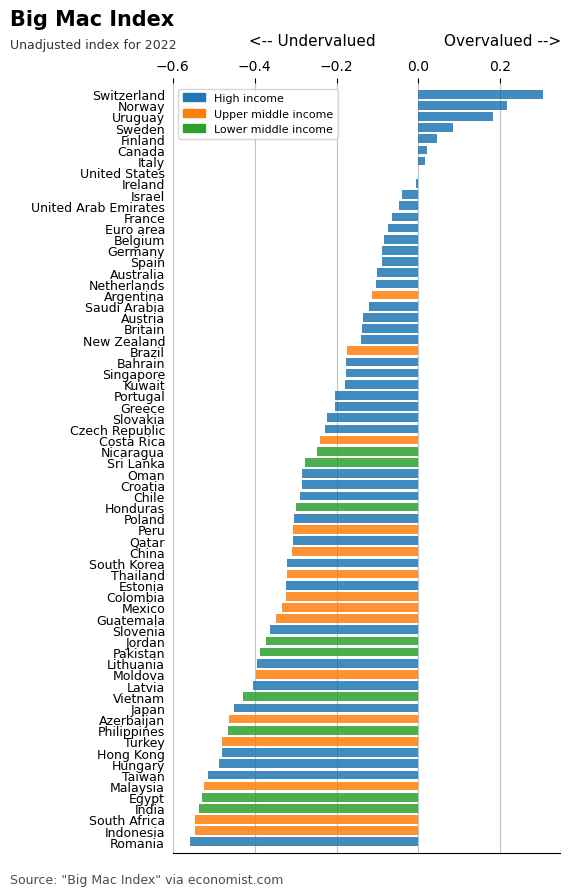

In [21]:
# | code-fold: true
# | echo: true
# | label: fig-big-mac-index
# | fig-cap: "Big Mac Index"

fig, ax = plt.subplots(figsize=(5, 10))
ax.spines[["top", "right", "left"]].set_visible(False)

ax.set_title(
    "Big Mac Index", loc="left", weight="bold", ha="left", fontsize=15, x=-0.42
)

ax.text(
    x=-0.2,
    y=0.915,
    s="Unadjusted index for 2022",
    transform=fig.transFigure,
    ha="left",
    fontsize=9,
    alpha=0.8,
)


# plotting the actual data

# assigning each income group a color
color_list = list(mcolors.TABLEAU_COLORS.values())
colors = {country: color_list[i] for i, country in enumerate(df.income_group.unique())}

# the actual plot
ax.barh(
    y=df.name,
    width=df.USD,
    alpha=0.85,
    height=0.78,
    color=[colors[income] for income in df.income_group],
    zorder=2,
)

# x axis things
ax.xaxis.tick_top()
ax.set_xlabel(
    "                 <-- Undervalued              Overvalued --> ",
    labelpad=10,
    fontsize=11,
)
ax.xaxis.set_label_position("top")

# fix and label the y axis
# ax.set_yticklabels(df.name, ha="left")
ax.yaxis.set_tick_params(pad=2, labelsize=9, bottom=False)
ax.set_ylim(-1, df.shape[0])


# legend for income groups
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f"{i}" for i in colors]
ax.legend(handles, labels, fontsize=8)
ax.grid(which="major", axis="x", color="#758D99", alpha=0.5, zorder=1)

# Set source text
ax.text(
    x=-0.2,
    y=0.08,
    s="""Source: "Big Mac Index" via economist.com""",
    transform=fig.transFigure,
    ha="left",
    fontsize=9,
    alpha=0.7,
)

phew! That is a long image, with too many countries, and its a bit ugly, so if this was going to be used somewhere, I'd filter the countries and produce a more sensible sized graph.

## Big Mac Index using Plotly

I should have probably gone with [plotly](https://plotly.com/graphing-libraries/) first for this, but here goes:

In [22]:
fig = px.bar(
    df, x="USD", y="name", width=600, height=800, text="name", color="income_group"
)
fig.update_layout(title_text="Big Mac Index", yaxis_categoryorder="total ascending")
fig.show()

## the end

Can play around a bit more with this data... but heaps enough for now. 